## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [3]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [6]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [9]:
## Load in the data set (Internet Access needed)

##url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('pima-indians-diabetes.data', names=names)

In [4]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
56,7,187,68,39,304,37.7,0.254,41,1
207,5,162,104,0,0,37.7,0.151,52,1
362,5,103,108,37,0,39.2,0.305,65,0
118,4,97,60,23,0,28.2,0.443,22,0
694,2,90,60,0,0,23.5,0.191,25,0


In [10]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [11]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [12]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [13]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [14]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.771
roc-auc is 0.832


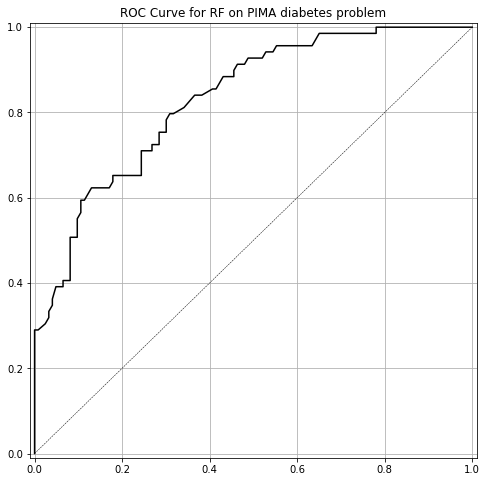

In [15]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [16]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [17]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [18]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 0s 159us/step - loss: 0.8153 - accuracy: 0.4358 - val_loss: 0.8052 - val_accuracy: 0.4896
Epoch 2/200
576/576 [==============================] - 0s 24us/step - loss: 0.7979 - accuracy: 0.4497 - val_loss: 0.7902 - val_accuracy: 0.5052
Epoch 3/200
576/576 [==============================] - 0s 25us/step - loss: 0.7818 - accuracy: 0.4670 - val_loss: 0.7762 - val_accuracy: 0.5208
Epoch 4/200
576/576 [==============================] - 0s 24us/step - loss: 0.7668 - accuracy: 0.4844 - val_loss: 0.7634 - val_accuracy: 0.5365
Epoch 5/200
576/576 [==============================] - 0s 23us/step - loss: 0.7531 - accuracy: 0.4983 - val_loss: 0.7513 - val_accuracy: 0.5417
Epoch 6/200
576/576 [==============================] - 0s 23us/step - loss: 0.7402 - accuracy: 0.5104 - val_loss: 0.7402 - val_accuracy: 0

Epoch 54/200
576/576 [==============================] - 0s 24us/step - loss: 0.5439 - accuracy: 0.6979 - val_loss: 0.5642 - val_accuracy: 0.7031
Epoch 55/200
576/576 [==============================] - 0s 21us/step - loss: 0.5426 - accuracy: 0.6997 - val_loss: 0.5630 - val_accuracy: 0.7031
Epoch 56/200
576/576 [==============================] - 0s 21us/step - loss: 0.5413 - accuracy: 0.6997 - val_loss: 0.5618 - val_accuracy: 0.7031
Epoch 57/200
576/576 [==============================] - 0s 21us/step - loss: 0.5400 - accuracy: 0.6997 - val_loss: 0.5607 - val_accuracy: 0.7083
Epoch 58/200
576/576 [==============================] - 0s 21us/step - loss: 0.5388 - accuracy: 0.7031 - val_loss: 0.5596 - val_accuracy: 0.7083
Epoch 59/200
576/576 [==============================] - 0s 24us/step - loss: 0.5376 - accuracy: 0.7049 - val_loss: 0.5585 - val_accuracy: 0.7135
Epoch 60/200
576/576 [==============================] - 0s 21us/step - loss: 0.5364 - accuracy: 0.7031 - val_loss: 0.5575 - val_ac

576/576 [==============================] - 0s 21us/step - loss: 0.4795 - accuracy: 0.7743 - val_loss: 0.5175 - val_accuracy: 0.7604
Epoch 167/200
576/576 [==============================] - 0s 23us/step - loss: 0.4793 - accuracy: 0.7743 - val_loss: 0.5174 - val_accuracy: 0.7552
Epoch 168/200
576/576 [==============================] - 0s 22us/step - loss: 0.4790 - accuracy: 0.7743 - val_loss: 0.5173 - val_accuracy: 0.7552
Epoch 169/200
576/576 [==============================] - 0s 22us/step - loss: 0.4788 - accuracy: 0.7760 - val_loss: 0.5171 - val_accuracy: 0.7500
Epoch 170/200
576/576 [==============================] - 0s 23us/step - loss: 0.4785 - accuracy: 0.7760 - val_loss: 0.5170 - val_accuracy: 0.7500
Epoch 171/200
576/576 [==============================] - 0s 21us/step - loss: 0.4783 - accuracy: 0.7760 - val_loss: 0.5169 - val_accuracy: 0.7500
Epoch 172/200
576/576 [==============================] - 0s 19us/step - loss: 0.4780 - accuracy: 0.7760 - val_loss: 0.5168 - val_accuracy:

In [19]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [20]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [21]:
y_pred_prob_nn_1[:10]

array([[0.46993592],
       [0.69098973],
       [0.32775742],
       [0.24328795],
       [0.22191903],
       [0.5633823 ],
       [0.07127056],
       [0.26652524],
       [0.71009123],
       [0.2628248 ]], dtype=float32)

accuracy is 0.750
roc-auc is 0.816


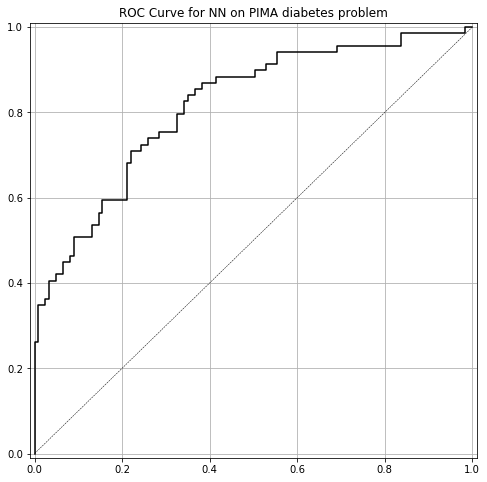

In [22]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [23]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

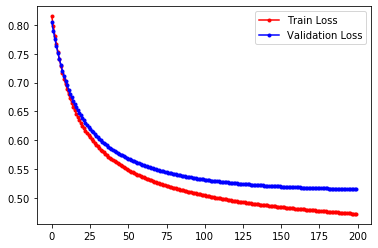

In [24]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [25]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 23us/step - loss: 0.4716 - accuracy: 0.7760 - val_loss: 0.5146 - val_accuracy: 0.7448
Epoch 2/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4714 - accuracy: 0.7760 - val_loss: 0.5145 - val_accuracy: 0.7448
Epoch 3/1000
576/576 [==============================] - 0s 26us/step - loss: 0.4712 - accuracy: 0.7778 - val_loss: 0.5144 - val_accuracy: 0.7448
Epoch 4/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4710 - accuracy: 0.7778 - val_loss: 0.5144 - val_accuracy: 0.7448
Epoch 5/1000
576/576 [==============================] - 0s 23us/step - loss: 0.4708 - accuracy: 0.7778 - val_loss: 0.5143 - val_accuracy: 0.7448
Epoch 6/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4706 - accuracy: 0.7778 - val_loss: 0.5143 - val_accuracy: 0.7448
Epoch 7/1000
576/576 [==============================] - 0s 24us/step - loss: 0.4704 

Epoch 57/1000
576/576 [==============================] - 0s 23us/step - loss: 0.4628 - accuracy: 0.7812 - val_loss: 0.5126 - val_accuracy: 0.7396
Epoch 58/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4626 - accuracy: 0.7812 - val_loss: 0.5126 - val_accuracy: 0.7396
Epoch 59/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4625 - accuracy: 0.7812 - val_loss: 0.5125 - val_accuracy: 0.7396
Epoch 60/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4624 - accuracy: 0.7812 - val_loss: 0.5125 - val_accuracy: 0.7396
Epoch 61/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4622 - accuracy: 0.7812 - val_loss: 0.5125 - val_accuracy: 0.7396
Epoch 62/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4621 - accuracy: 0.7812 - val_loss: 0.5125 - val_accuracy: 0.7396
Epoch 63/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4620 - accuracy: 0.7812 - val_loss: 0.5124 -

576/576 [==============================] - 0s 21us/step - loss: 0.4561 - accuracy: 0.7778 - val_loss: 0.5114 - val_accuracy: 0.7448
Epoch 114/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4560 - accuracy: 0.7778 - val_loss: 0.5114 - val_accuracy: 0.7448
Epoch 115/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4558 - accuracy: 0.7778 - val_loss: 0.5114 - val_accuracy: 0.7448
Epoch 116/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4558 - accuracy: 0.7778 - val_loss: 0.5114 - val_accuracy: 0.7448
Epoch 117/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4556 - accuracy: 0.7778 - val_loss: 0.5114 - val_accuracy: 0.7448
Epoch 118/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4555 - accuracy: 0.7760 - val_loss: 0.5113 - val_accuracy: 0.7448
Epoch 119/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4554 - accuracy: 0.7760 - val_loss: 0.5113 - val_acc

Epoch 169/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4507 - accuracy: 0.7830 - val_loss: 0.5107 - val_accuracy: 0.7500
Epoch 170/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4506 - accuracy: 0.7830 - val_loss: 0.5107 - val_accuracy: 0.7500
Epoch 171/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4506 - accuracy: 0.7812 - val_loss: 0.5107 - val_accuracy: 0.7500
Epoch 172/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4504 - accuracy: 0.7812 - val_loss: 0.5107 - val_accuracy: 0.7500
Epoch 173/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4504 - accuracy: 0.7812 - val_loss: 0.5106 - val_accuracy: 0.7500
Epoch 174/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4503 - accuracy: 0.7830 - val_loss: 0.5106 - val_accuracy: 0.7500
Epoch 175/1000
576/576 [==============================] - 0s 17us/step - loss: 0.4502 - accuracy: 0.7830 - val_loss: 0

Epoch 225/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4461 - accuracy: 0.7865 - val_loss: 0.5106 - val_accuracy: 0.7552
Epoch 226/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4460 - accuracy: 0.7865 - val_loss: 0.5106 - val_accuracy: 0.7552
Epoch 227/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4459 - accuracy: 0.7865 - val_loss: 0.5106 - val_accuracy: 0.7552
Epoch 228/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4459 - accuracy: 0.7865 - val_loss: 0.5106 - val_accuracy: 0.7552
Epoch 229/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4458 - accuracy: 0.7865 - val_loss: 0.5106 - val_accuracy: 0.7552
Epoch 230/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4457 - accuracy: 0.7865 - val_loss: 0.5106 - val_accuracy: 0.7552
Epoch 231/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4456 - accuracy: 0.7882 - val_loss: 0

Epoch 281/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4425 - accuracy: 0.7899 - val_loss: 0.5105 - val_accuracy: 0.7552
Epoch 282/1000
576/576 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.78 - 0s 19us/step - loss: 0.4424 - accuracy: 0.7899 - val_loss: 0.5105 - val_accuracy: 0.7552
Epoch 283/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4423 - accuracy: 0.7899 - val_loss: 0.5105 - val_accuracy: 0.7552
Epoch 284/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4423 - accuracy: 0.7899 - val_loss: 0.5105 - val_accuracy: 0.7552
Epoch 285/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4422 - accuracy: 0.7899 - val_loss: 0.5105 - val_accuracy: 0.7552
Epoch 286/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4422 - accuracy: 0.7882 - val_loss: 0.5105 - val_accuracy: 0.7552
Epoch 287/1000
576/576 [==============================] - 0s 21us/step - los

Epoch 392/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4374 - accuracy: 0.7917 - val_loss: 0.5103 - val_accuracy: 0.7552
Epoch 393/1000
576/576 [==============================] - 0s 23us/step - loss: 0.4374 - accuracy: 0.7917 - val_loss: 0.5103 - val_accuracy: 0.7552
Epoch 394/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4373 - accuracy: 0.7917 - val_loss: 0.5103 - val_accuracy: 0.7552
Epoch 395/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4373 - accuracy: 0.7899 - val_loss: 0.5103 - val_accuracy: 0.7552
Epoch 396/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4373 - accuracy: 0.7899 - val_loss: 0.5103 - val_accuracy: 0.7552
Epoch 397/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4372 - accuracy: 0.7899 - val_loss: 0.5103 - val_accuracy: 0.7552
Epoch 398/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4372 - accuracy: 0.7899 - val_loss: 0

Epoch 448/1000
576/576 [==============================] - 0s 47us/step - loss: 0.4352 - accuracy: 0.7917 - val_loss: 0.5101 - val_accuracy: 0.7656
Epoch 449/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4352 - accuracy: 0.7917 - val_loss: 0.5101 - val_accuracy: 0.7656
Epoch 450/1000
576/576 [==============================] - 0s 24us/step - loss: 0.4351 - accuracy: 0.7917 - val_loss: 0.5101 - val_accuracy: 0.7656
Epoch 451/1000
576/576 [==============================] - 0s 23us/step - loss: 0.4351 - accuracy: 0.7917 - val_loss: 0.5101 - val_accuracy: 0.7656
Epoch 452/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4351 - accuracy: 0.7917 - val_loss: 0.5101 - val_accuracy: 0.7656
Epoch 453/1000
576/576 [==============================] - 0s 24us/step - loss: 0.4350 - accuracy: 0.7917 - val_loss: 0.5101 - val_accuracy: 0.7656
Epoch 454/1000
576/576 [==============================] - 0s 26us/step - loss: 0.4350 - accuracy: 0.7917 - val_loss: 0

Epoch 504/1000
576/576 [==============================] - 0s 23us/step - loss: 0.4332 - accuracy: 0.7917 - val_loss: 0.5099 - val_accuracy: 0.7656
Epoch 505/1000
576/576 [==============================] - 0s 23us/step - loss: 0.4332 - accuracy: 0.7934 - val_loss: 0.5099 - val_accuracy: 0.7656
Epoch 506/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4332 - accuracy: 0.7917 - val_loss: 0.5099 - val_accuracy: 0.7656
Epoch 507/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4331 - accuracy: 0.7917 - val_loss: 0.5099 - val_accuracy: 0.7656
Epoch 508/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4331 - accuracy: 0.7934 - val_loss: 0.5099 - val_accuracy: 0.7656
Epoch 509/1000
576/576 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.81 - 0s 21us/step - loss: 0.4330 - accuracy: 0.7917 - val_loss: 0.5099 - val_accuracy: 0.7656
Epoch 510/1000
576/576 [==============================] - 0s 21us/step - los

576/576 [==============================] - 0s 21us/step - loss: 0.4297 - accuracy: 0.7951 - val_loss: 0.5104 - val_accuracy: 0.7604
Epoch 615/1000
576/576 [==============================] - 0s 23us/step - loss: 0.4297 - accuracy: 0.7951 - val_loss: 0.5104 - val_accuracy: 0.7604
Epoch 616/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4296 - accuracy: 0.7951 - val_loss: 0.5104 - val_accuracy: 0.7604
Epoch 617/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4296 - accuracy: 0.7951 - val_loss: 0.5105 - val_accuracy: 0.7604
Epoch 618/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4296 - accuracy: 0.7951 - val_loss: 0.5105 - val_accuracy: 0.7604
Epoch 619/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4296 - accuracy: 0.7951 - val_loss: 0.5105 - val_accuracy: 0.7604
Epoch 620/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4295 - accuracy: 0.7951 - val_loss: 0.5105 - val_acc

Epoch 725/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4262 - accuracy: 0.7969 - val_loss: 0.5114 - val_accuracy: 0.7604
Epoch 726/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4262 - accuracy: 0.7969 - val_loss: 0.5114 - val_accuracy: 0.7604
Epoch 727/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4261 - accuracy: 0.7969 - val_loss: 0.5114 - val_accuracy: 0.7604
Epoch 728/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4261 - accuracy: 0.7969 - val_loss: 0.5114 - val_accuracy: 0.7604
Epoch 729/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4261 - accuracy: 0.7969 - val_loss: 0.5115 - val_accuracy: 0.7604
Epoch 730/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4260 - accuracy: 0.7951 - val_loss: 0.5115 - val_accuracy: 0.7604
Epoch 731/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4260 - accuracy: 0.7969 - val_loss: 0

Epoch 781/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4246 - accuracy: 0.7934 - val_loss: 0.5123 - val_accuracy: 0.7656
Epoch 782/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4246 - accuracy: 0.7934 - val_loss: 0.5123 - val_accuracy: 0.7656
Epoch 783/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4245 - accuracy: 0.7934 - val_loss: 0.5123 - val_accuracy: 0.7656
Epoch 784/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4245 - accuracy: 0.7934 - val_loss: 0.5123 - val_accuracy: 0.7656
Epoch 785/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4245 - accuracy: 0.7934 - val_loss: 0.5123 - val_accuracy: 0.7656
Epoch 786/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4245 - accuracy: 0.7934 - val_loss: 0.5123 - val_accuracy: 0.7656
Epoch 787/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4245 - accuracy: 0.7934 - val_loss: 0

Epoch 837/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4232 - accuracy: 0.7917 - val_loss: 0.5129 - val_accuracy: 0.7656
Epoch 838/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4232 - accuracy: 0.7917 - val_loss: 0.5129 - val_accuracy: 0.7656
Epoch 839/1000
576/576 [==============================] - 0s 24us/step - loss: 0.4232 - accuracy: 0.7917 - val_loss: 0.5129 - val_accuracy: 0.7656
Epoch 840/1000
576/576 [==============================] - 0s 24us/step - loss: 0.4231 - accuracy: 0.7917 - val_loss: 0.5129 - val_accuracy: 0.7656
Epoch 841/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4231 - accuracy: 0.7917 - val_loss: 0.5129 - val_accuracy: 0.7656
Epoch 842/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4231 - accuracy: 0.7917 - val_loss: 0.5130 - val_accuracy: 0.7656
Epoch 843/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4230 - accuracy: 0.7917 - val_loss: 0

Epoch 948/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4205 - accuracy: 0.7899 - val_loss: 0.5143 - val_accuracy: 0.7656
Epoch 949/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4205 - accuracy: 0.7899 - val_loss: 0.5143 - val_accuracy: 0.7656
Epoch 950/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4205 - accuracy: 0.7899 - val_loss: 0.5143 - val_accuracy: 0.7656
Epoch 951/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4204 - accuracy: 0.7899 - val_loss: 0.5143 - val_accuracy: 0.7656
Epoch 952/1000
576/576 [==============================] - 0s 21us/step - loss: 0.4204 - accuracy: 0.7899 - val_loss: 0.5143 - val_accuracy: 0.7656
Epoch 953/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4204 - accuracy: 0.7899 - val_loss: 0.5143 - val_accuracy: 0.7656
Epoch 954/1000
576/576 [==============================] - 0s 19us/step - loss: 0.4203 - accuracy: 0.7899 - val_loss: 0

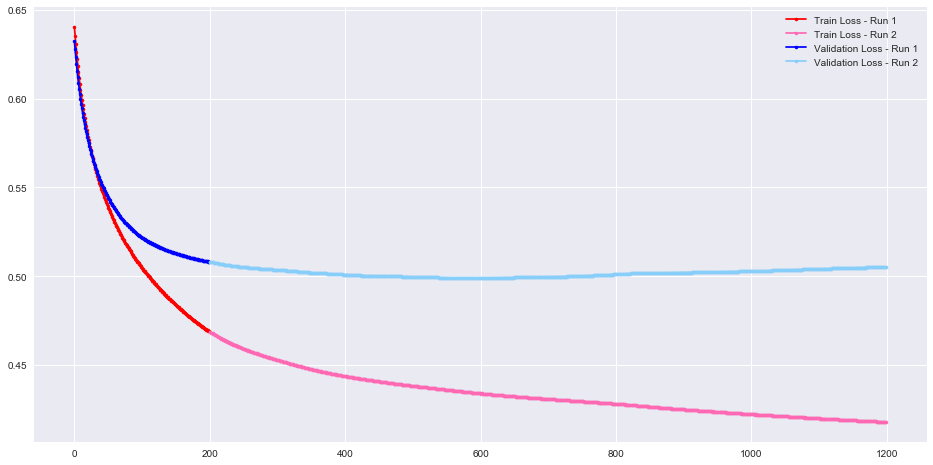

In [22]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures